<a href="https://colab.research.google.com/github/NancyBiyahut/intrusion-detection-autoencoder/blob/main/LSTMautoencoder_cic_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from mpl_toolkits import mplot3d
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from scipy.spatial.distance import euclidean
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [63]:
df1= pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3 = pd.read_csv('Friday-WorkingHours-Morning.pcap_ISCX.csv')
df = pd.concat([df1, df2, df3], ignore_index=True)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [65]:
# List all column names and their data types
column_datatypes = df.dtypes

# Print column names and their data types
for column_name, datatype in column_datatypes.items():
    print(f"Column: {column_name}, Datatype: {datatype}")

Column:  Destination Port, Datatype: int64
Column:  Flow Duration, Datatype: int64
Column:  Total Fwd Packets, Datatype: int64
Column:  Total Backward Packets, Datatype: int64
Column: Total Length of Fwd Packets, Datatype: int64
Column:  Total Length of Bwd Packets, Datatype: int64
Column:  Fwd Packet Length Max, Datatype: int64
Column:  Fwd Packet Length Min, Datatype: int64
Column:  Fwd Packet Length Mean, Datatype: float64
Column:  Fwd Packet Length Std, Datatype: float64
Column: Bwd Packet Length Max, Datatype: int64
Column:  Bwd Packet Length Min, Datatype: float64
Column:  Bwd Packet Length Mean, Datatype: float64
Column:  Bwd Packet Length Std, Datatype: float64
Column: Flow Bytes/s, Datatype: float64
Column:  Flow Packets/s, Datatype: float64
Column:  Flow IAT Mean, Datatype: float64
Column:  Flow IAT Std, Datatype: float64
Column:  Flow IAT Max, Datatype: float64
Column:  Flow IAT Min, Datatype: float64
Column: Fwd IAT Total, Datatype: float64
Column:  Fwd IAT Mean, Datatype: 

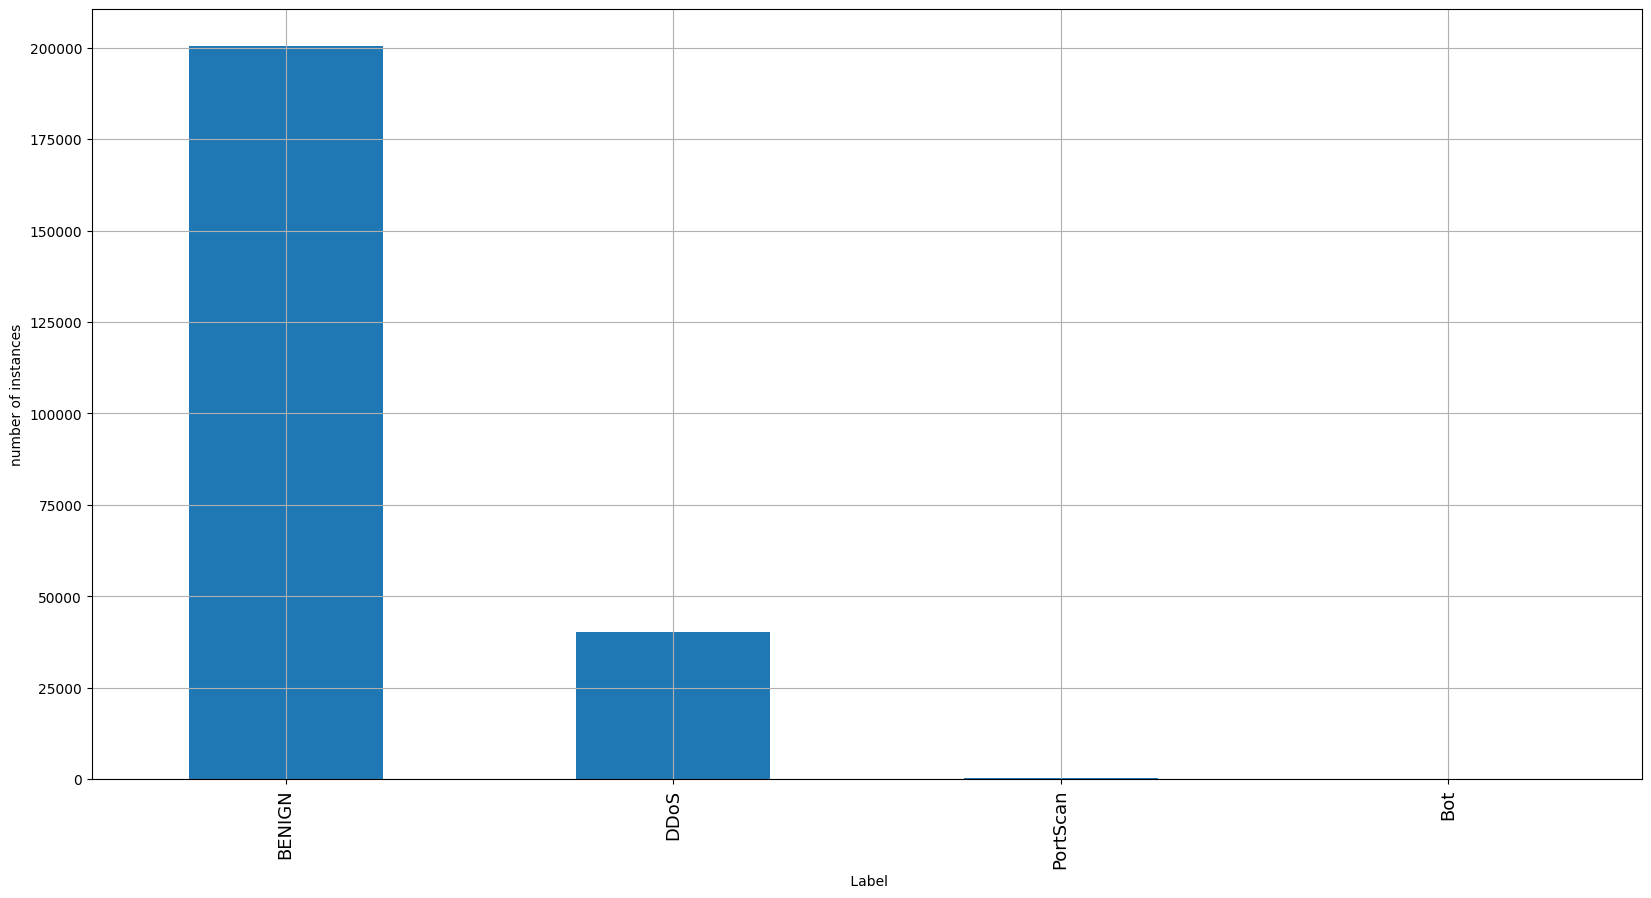

In [67]:
pd.value_counts(df[' Label']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [68]:
normal_instances = df[df[' Label']=='BENIGN'].shape[0]
anomalous_instances = df[df[' Label']!='BENIGN'].shape[0]
print(normal_instances)
print(anomalous_instances)
print('percentage of anomalies = {}'.format(100*anomalous_instances/normal_instances))

200492
40874
percentage of anomalies = 20.386848353051494


In [103]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=[' Label'])  # Features
y = df[' Label']  # Target variable
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
df_http_normal = X_train
df_http_normal.shape

(192992, 78)

In [109]:
# Check for infinite or NaN values
print(df_http_normal.isnull().sum())  # Check for NaN values
print(df_http_normal.isin([np.inf, -np.inf]).sum())  # Check for infinite values

# Drop rows containing infinite or NaN values
df_http_normal = df_http_normal.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
df_http_normal = df_http_normal.dropna()  # Drop rows with NaN values



 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
 Active Min                    0
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
Length: 78, dtype: int64
 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
 Active Min                    0
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
Length: 78, dtype: int64


In [110]:
df_http_normal.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,192992.000000,1.929920e+05,192992.000000,192992.000000,1.929920e+05,1.929920e+05,192992.000000,192992.000000,192992.000000,192992.000000,...,192992.000000,192992.000000,1.929920e+05,1.929920e+05,1.929920e+05,1.929920e+05,1.929920e+05,1.929920e+05,1.929920e+05,1.929920e+05
mean,6800.314873,1.279637e+07,12.068894,14.111404,6.360562e+02,2.441293e+04,234.973455,23.765773,72.388778,79.897267,...,9.077599,24.143301,1.078926e+05,4.264525e+04,1.884085e+05,8.436418e+04,5.406915e+06,9.832953e+05,6.107346e+06,4.673843e+06
std,16950.715514,3.050586e+07,1013.089816,1364.102049,7.201491e+03,3.071919e+06,928.917134,87.665037,248.097711,376.492602,...,966.552950,6.030721,7.417359e+05,3.638569e+05,1.106428e+06,6.787605e+05,1.562364e+07,6.093254e+06,1.749932e+07,1.481397e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,2.440000e+02,2.000000,1.000000,2.600000e+01,6.000000e+00,6.000000,0.000000,6.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,6.140000e+04,2.000000,2.000000,6.000000e+01,1.570000e+02,35.000000,6.000000,33.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,4.611561e+06,4.000000,5.000000,1.230000e+02,1.069000e+03,54.000000,38.000000,48.000000,10.263203,...,3.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65300.000000,1.199999e+08,207964.000000,284602.000000,1.235152e+06,6.270000e+08,24820.000000,1472.000000,3867.000000,6692.644993,...,198636.000000,56.000000,1.000000e+08,4.230000e+07,1.000000e+08,1.000000e+08,1.200000e+08,7.420000e+07,1.200000e+08,1.200000e+08


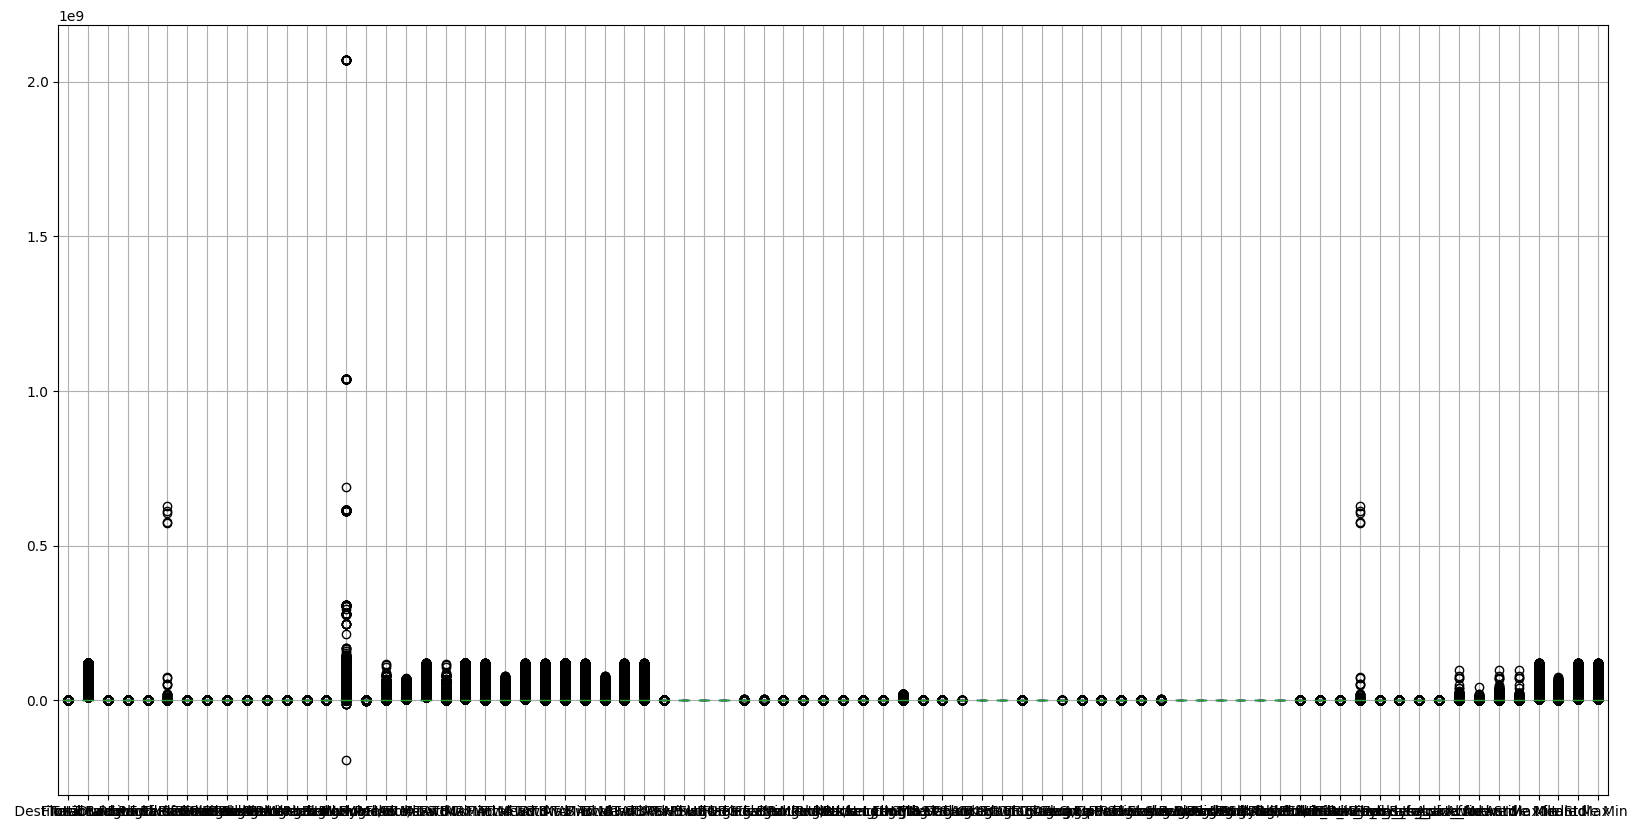

In [111]:
df_http_normal.boxplot(figsize=(20, 10))
plt.show()

In [112]:
# scaling the data using standard scaler
scaler = StandardScaler()
df_http_normal = pd.DataFrame(scaler.fit_transform(df_http_normal), columns=df_http_normal.columns)

In [113]:
# reducing the dimensionality of the data using PCA and covering 80% of the variance in the original data
pca = PCA(n_components=0.80)
pca.fit(df_http_normal)

PCA(n_components=0.8)

In [114]:
pca_cols = ['PCA_'+ str(i) for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca.transform(df_http_normal), columns=pca_cols)

In [115]:
df_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,-1.971761,0.381107,1.007222,1.031798,-1.199960,2.007856,-1.946381,-0.226197,-1.906161,1.228140,2.574141
1,4.560310,-0.491245,-1.587866,0.575904,4.556974,2.881997,-0.289877,2.689248,-0.232396,-0.109092,-1.135890
2,-1.353157,0.207254,0.916238,-0.070893,-0.166263,0.743103,-0.511993,-0.953136,-0.157880,0.116520,-0.028639
3,-2.036130,0.381252,0.897339,-0.611339,0.868389,-1.991544,1.600855,-0.109712,1.015683,-0.644322,-0.019695
4,-1.841491,0.348465,0.644512,-0.571081,0.667139,-0.866672,0.711676,-0.295903,0.759364,-0.468439,0.199067


In [116]:
def get_windows(df, window_size=20, stride=10):
  windows_arr = []
  for i in tqdm.tqdm(range(0, len(df)-window_size+1, stride)):
    windows_arr.append(df.iloc[i:i+window_size, :].to_numpy())
  return np.array(windows_arr)

In [117]:
window_size, stride = 10, 10
windows_arr = get_windows(df_pca, window_size, stride)

100%|██████████| 19299/19299 [00:01<00:00, 16953.50it/s]


In [118]:
# shuffling windows for training purpose
indices = np.arange(windows_arr.shape[0])
np.random.shuffle(indices)
windows_shuffled = windows_arr[indices]

LSTM Autoencoder

In [119]:
K.clear_session()
# encoder model with stacked LSTM
encoder = Sequential([LSTM(80, return_sequences=True, activation='selu',input_shape=(window_size, 11), dropout=0.2), LSTM(50, activation='selu', return_sequences=True),
                      LSTM(20, activation='selu')], name='encoder')
# decoder model with output dimension same as input dimension
decoder = Sequential([RepeatVector(window_size), LSTM(50, activation='selu', return_sequences=True), LSTM(80, activation='selu',return_sequences=True),
                      TimeDistributed(Dense(11, activation='linear'))], name='decoder')
# creating sequential autoencoder using encoder, decoder as layers
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(optimizer='adam', loss = tf.keras.losses.Huber(100.))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 20)                61320     
                                                                 
 decoder (Sequential)        (None, 10, 11)            57011     
                                                                 
Total params: 118331 (462.23 KB)
Trainable params: 118331 (462.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [120]:
encoder.summary(), decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 80)            29440     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            26200     
                                                                 
 lstm_2 (LSTM)               (None, 20)                5680      
                                                                 
Total params: 61320 (239.53 KB)
Trainable params: 61320 (239.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVecto  (None, 10, 20)            0         
 r)                                                              
    

(None, None)

In [121]:
check_point = tf.keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
train_hist = autoencoder.fit(windows_shuffled, windows_shuffled[:, :, ::-1], batch_size=64, validation_split=0.2, epochs=100, callbacks=[check_point])

Epoch 1/100
241/242 [============================>.] - ETA: 0s - loss: 1.9493
Epoch 1: val_loss improved from inf to 1.65965, saving model to autoencoder.h5
242/242 [==============================] - 23s 60ms/step - loss: 1.9487 - val_loss: 1.6597
Epoch 2/100
  3/242 [..............................] - ETA: 9s - loss: 1.8288 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 [==============================] - ETA: 0s - loss: 1.6639
Epoch 2: val_loss improved from 1.65965 to 1.37338, saving model to autoencoder.h5
242/242 [==============================] - 13s 55ms/step - loss: 1.6639 - val_loss: 1.3734
Epoch 3/100
242/242 [==============================] - ETA: 0s - loss: 1.4418
Epoch 3: val_loss improved from 1.37338 to 1.23968, saving model to autoencoder.h5
242/242 [==============================] - 14s 59ms/step - loss: 1.4418 - val_loss: 1.2397
Epoch 4/100
242/242 [==============================] - ETA: 0s - loss: 1.3879
Epoch 4: val_loss improved from 1.23968 to 1.16859, saving model to autoencoder.h5
242/242 [==============================] - 14s 58ms/step - loss: 1.3879 - val_loss: 1.1686
Epoch 5/100
241/242 [============================>.] - ETA: 0s - loss: 1.3151
Epoch 5: val_loss improved from 1.16859 to 1.13820, saving model to autoencoder.h5
242/242 [==============================] - 14s 57ms/step - loss: 1.3150 - val_loss: 1.1382
Epoc

In [122]:
# restoring the best model
autoencoder_loaded = tf.keras.models.load_model('autoencoder.h5')

Testing

In [155]:
np.random.seed(42)

# Sample a small subset of data for testing (e.g., 20%)
test_df_http = df.sample(frac=0.2, random_state=42)

test_df_http = test_df_http.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
test_df_http = test_df_http.dropna()

In [156]:
# binary indicator to represent anomalies
status = pd.Series([0 if i=='BENIGN' else 1 for i in test_df_http[' Label']])
test_labels = [1 if np.sum(status[i:i+window_size])>0 else 0 for i in range(0, len(status)-window_size+1, stride)]

In [157]:
test_df_http = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [158]:
test_df_http_pca = pd.DataFrame(pca.transform(test_df_http), columns=pca_cols)
test_df_http_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,-0.223066,-0.098638,1.404128,-0.273818,-0.187568,0.941988,-0.489025,-1.462565,0.028108,-0.012751,-0.037366
1,-1.741927,0.313296,0.927739,0.576680,-0.637628,0.600180,-0.633904,-1.355278,-1.347485,0.890950,-0.155789
2,-1.898782,0.356164,0.618962,-0.648156,0.644940,-1.561760,1.413136,-0.277259,0.846852,-0.508295,0.168870
3,2.985842,1.366271,-1.777268,6.662151,0.504578,-4.279155,-1.718177,3.686713,-1.450932,1.081102,2.041700
4,-1.807874,0.336967,0.653688,-0.425910,0.548257,-0.385081,0.192852,-0.272061,0.439026,-0.271525,0.191523


In [159]:
test_windows = get_windows(test_df_http_pca, window_size=10, stride=10)

100%|██████████| 4824/4824 [00:00<00:00, 14553.92it/s]


In [160]:
test_windows_pred = autoencoder_loaded.predict(test_windows)

151/151 [==============================] - 2s 12ms/step


In [161]:
# calculating reconstruction error for each sample
# implemented in tensorflow for faster execution when gpu is available

def get_recon_erros(true_windows, pred_windows):
  recon_errors = []

  def cond(y_true, y_pred, i, iters):
    return tf.less(i, iters)

  def body(y_true, y_pred, i, iters):
    tensor_for_error = tf.math.subtract(tf.slice(y_true, [i, 0, 0], [1, -1, -1]), tf.slice(y_pred, [i, 0, 0], [1, -1, -1]))
    tensor_for_error = tf.reshape(tensor_for_error, [window_size, pca.n_components_])
    recon_error = tf.math.reduce_mean(tf.norm(tensor_for_error, ord='euclidean', axis=1))
    # this is the list initialized above
    recon_errors.append(recon_error.numpy())
    return [y_true, y_pred, tf.add(i, 1), iters]

  iters = tf.constant(len(true_windows))

  result = tf.while_loop(cond, body, [tf.constant(true_windows.astype(np.float32)), tf.constant(pred_windows.astype(np.float32)), 0, iters])
  return recon_errors

In [162]:
recon_errors = get_recon_erros(test_windows, test_windows_pred)
recon_errors = np.array(recon_errors).reshape(-1, 1)

In [163]:
# scaling the reconstruction errors set to [0, 1] scale
mm_scaler = MinMaxScaler()
anomaly_scores = mm_scaler.fit_transform(recon_errors).flatten()

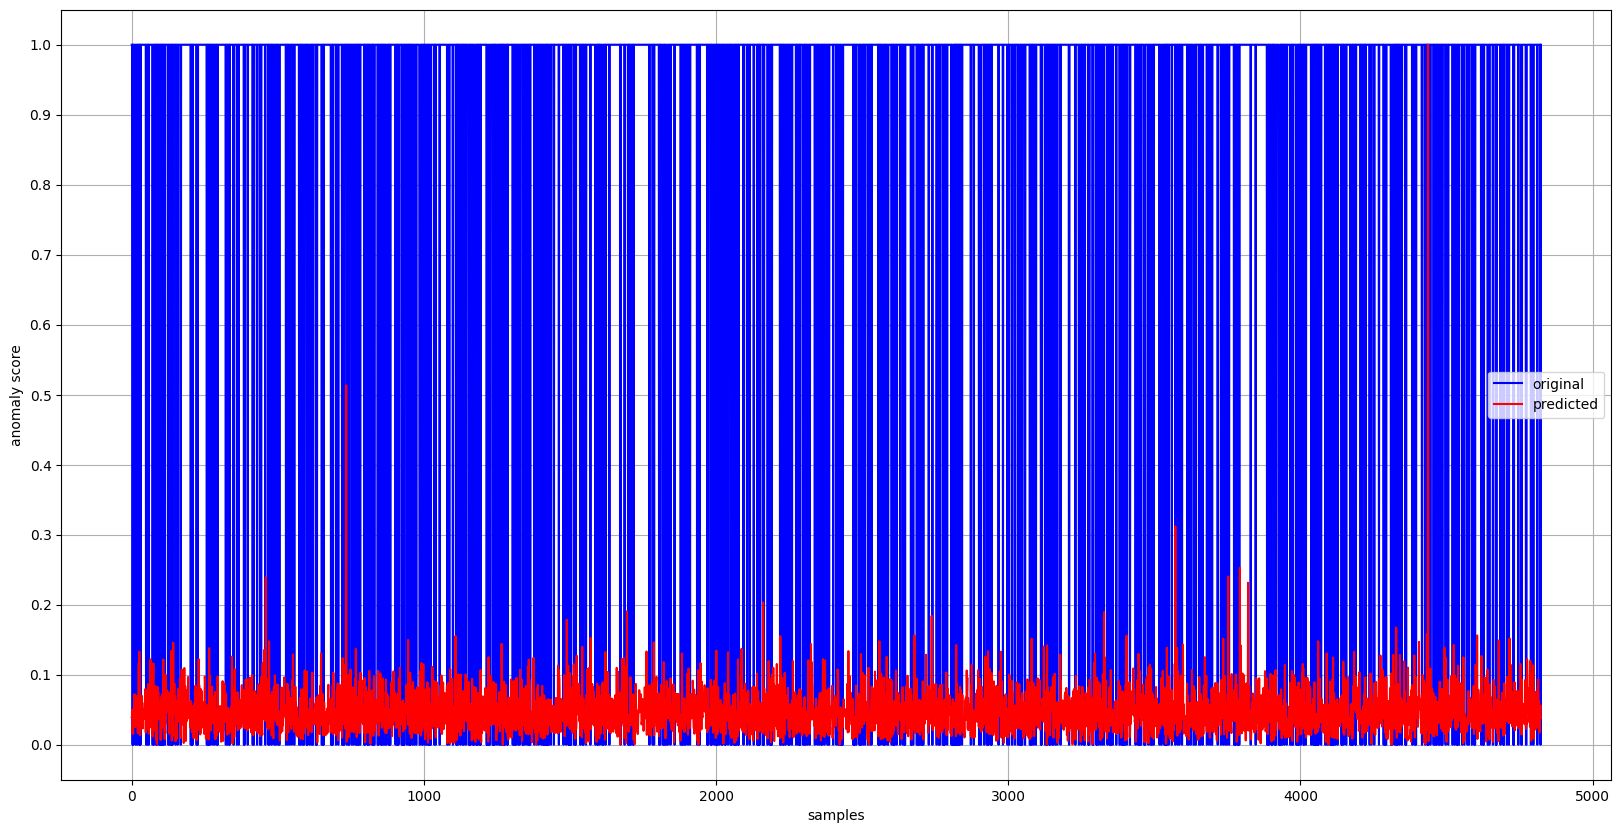

In [164]:
plt.figure(figsize=(20, 10))
plt.plot(test_labels, c='blue', label='original')
plt.plot(anomaly_scores, c='red', label='predicted')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.grid()
plt.legend()
plt.show()

Measuring the effectiveness of classifier

In [165]:
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)

In [166]:
auc = roc_auc_score(test_labels, anomaly_scores)
print('Area under ROC curve: {}'.format(auc))

Area under ROC curve: 0.6272632769302725


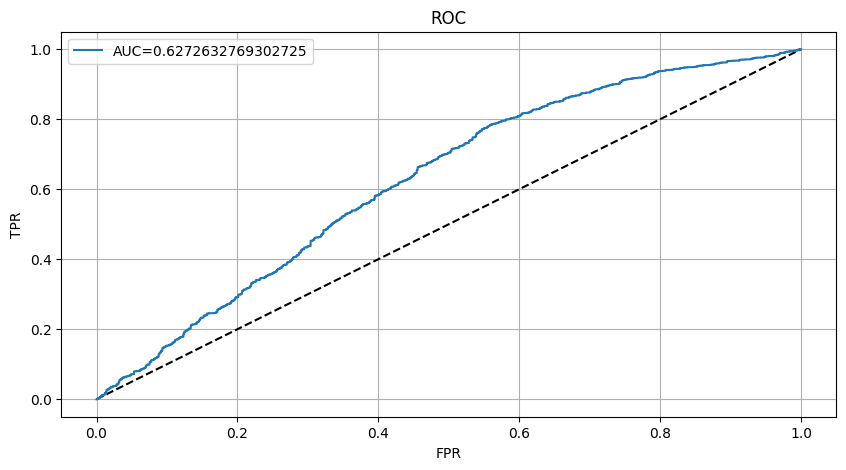

In [167]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color = 'black', linestyle='--')
plt.plot(fpr, tpr, label='AUC={}'.format(auc))
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()


Identifying anomalies in test set

In [168]:
anomaly_combinations = [(anomaly_scores>i).astype(np.int32) for i in thresholds]
f1_scores = [f1_score(test_labels, i) for i in anomaly_combinations]

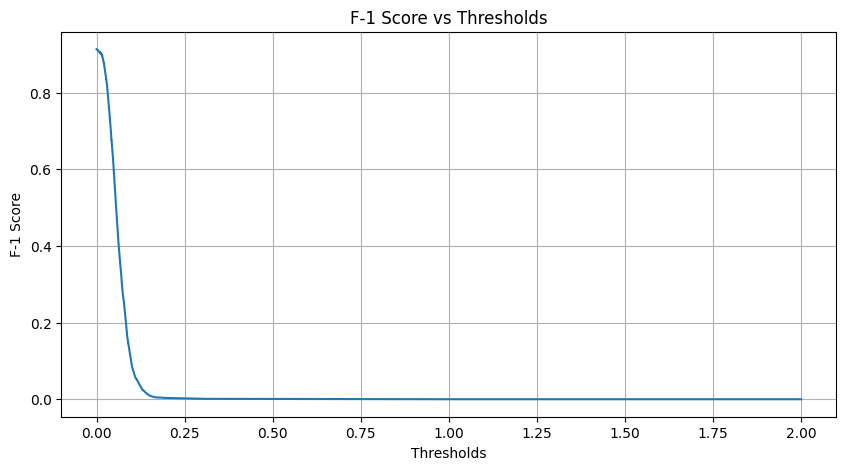

In [169]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.title('F-1 Score vs Thresholds')
plt.show()

In [170]:
max_f1_score = np.max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1_score)]
print('best threshold = {}'.format(best_threshold))

best threshold = 0.0


In [172]:
anomaly_indicator = (anomaly_scores>best_threshold).astype(np.int32)

In [173]:
confusion_matrix(test_labels, anomaly_indicator)

array([[   1,  769],
       [   0, 4054]])

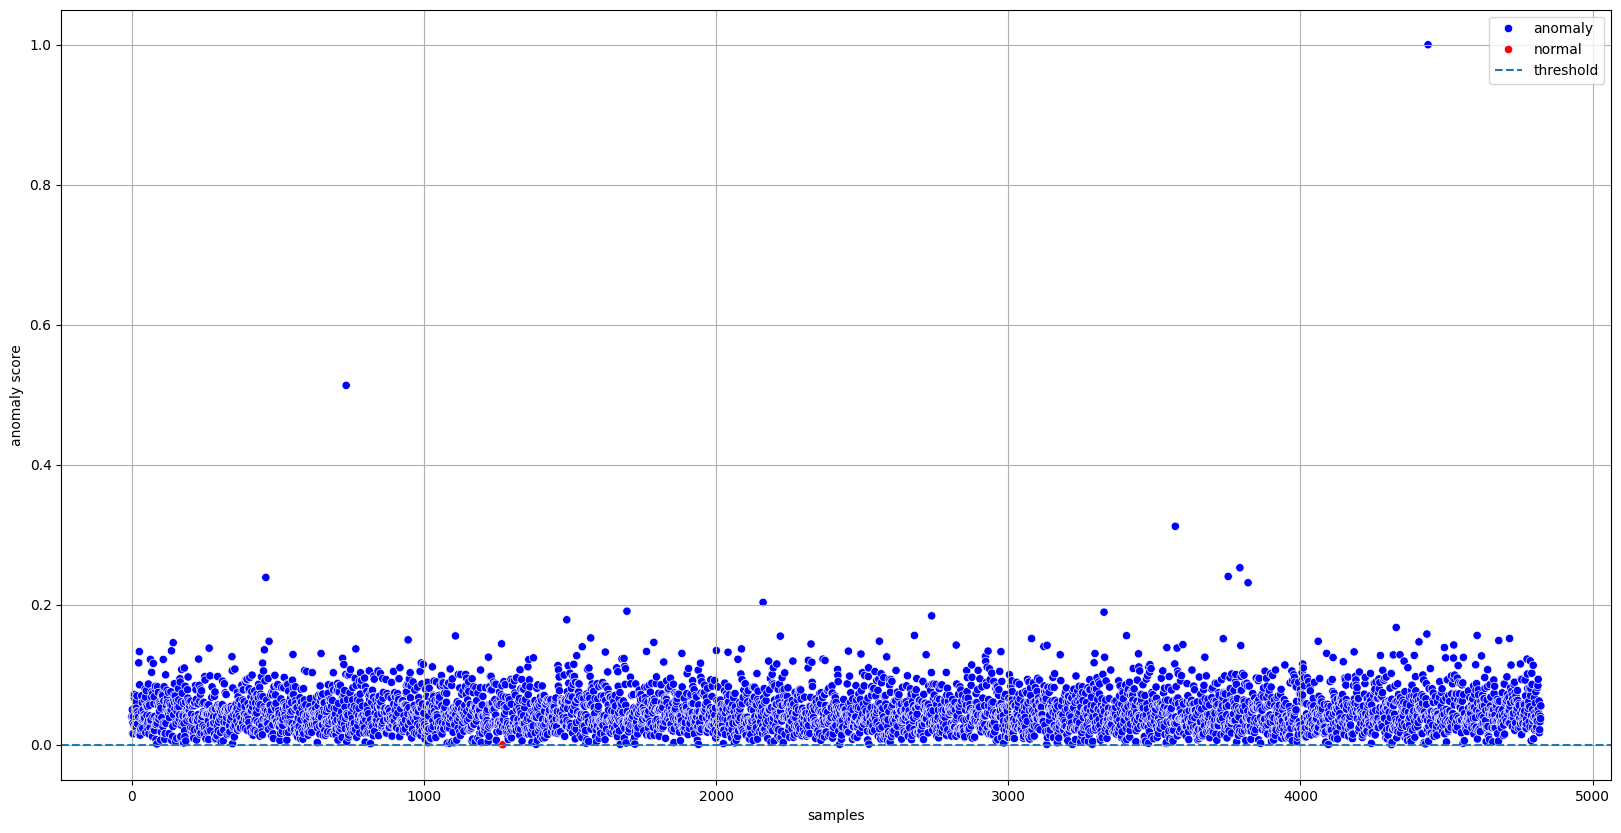

In [174]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(anomaly_scores)), y= anomaly_scores, hue=['normal' if i==0 else 'anomaly' for i in anomaly_indicator],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = best_threshold, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

In [175]:
precision = precision_score(test_labels, anomaly_indicator)
recall = recall_score(test_labels, anomaly_indicator)
f1_sc = f1_score(test_labels, anomaly_indicator)
accuracy_sc = accuracy_score(test_labels, anomaly_indicator)

In [176]:
print('Model has the following classification metrics:\n precision = {}\n recall = {}\n f1_score = {}\n accuracy_score = {}'
      .format(precision, recall, f1_sc, accuracy_sc))

Model has the following classification metrics:
 precision = 0.84055567074435
 recall = 1.0
 f1_score = 0.9133716345612256
 accuracy_score = 0.8405887230514096
